In [159]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime
from groq import Groq
import os
import re

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [160]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [161]:
class Config:

    STOCKS_US = [
        'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META',
        'JPM', 'JNJ', 'V', 'PG', 'XOM', 'CVX', 'LLY', 'KO'
    ]

    STOCKS_INDIA = [
        'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS',
        'ICICIBANK.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS',
        'SBIN.NS', 'ITC.NS', 'LTIM.NS', 'MARUTI.NS',
        'KOTAKBANK.NS', 'ONGC.NS', 'TATAMOTORS.NS', 'NTPC.NS'
    ]

    TICKERS = STOCKS_INDIA
    BENCHMARK_TICKER = '^NSEI'

    START_DATE = datetime.datetime(2000, 1, 1)
    END_DATE = datetime.datetime(2024, 12, 31)

    TRAIN_END = datetime.datetime(2018, 12, 31)
    VALID_END = datetime.datetime(2021, 12, 31)

    TRANSACTION_COST = 0.001

    OPENAI_API_KEY = ""

In [162]:
def download_ohlcv(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, interval='1d')
    if not isinstance(data.columns, pd.MultiIndex):
        if data.empty:
            raise ValueError("No data downloaded. Check tickers and date range.")
        data.columns = pd.MultiIndex.from_product([data.columns, tickers])
    return data

def get_cleaned_data(tickers, start, end):
    raw_data = download_ohlcv(tickers, start, end)
    ohlcv_data = {}
    for ticker in tickers:
        df = raw_data.xs(ticker, level=1, axis=1).copy()
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
        df.ffill(inplace=True)
        df = df[df['Volume'] > 0]
        df.dropna(inplace=True)
        if not df.empty:
            ohlcv_data[ticker] = df

    common_index = None
    for ticker, df in ohlcv_data.items():
        if common_index is None:
            common_index = df.index
        else:
            common_index = common_index.intersection(df.index)


    for ticker in list(ohlcv_data.keys()):
        ohlcv_data[ticker] = ohlcv_data[ticker].reindex(common_index)
        if ohlcv_data[ticker].isnull().values.any():
            del ohlcv_data[ticker]

    return ohlcv_data

In [163]:
def compute_indicators(df):
    df = df.copy()
    # SMA
    df.ta.sma(length=10, append=True)   # SMA_10
    df.ta.sma(length=20, append=True)   # SMA_20
    df.ta.sma(length=50, append=True)   # SMA_50
    df.ta.sma(length=200, append=True)  # SMA_200

    # EMA
    df.ta.ema(length=10, append=True)   # EMA_10
    df.ta.ema(length=20, append=True)   # EMA_20

    # RSI
    df.ta.rsi(length=14, append=True)   # RSI_14

    # Momentum
    df.ta.mom(length=10, append=True)   # MOM_10
    df.ta.mom(length=20, append=True)   # MOM_20

    # Bollinger Bands
    df.ta.bbands(length=20, std=2, append=True)
    # BBL_20_2.0, BBM_20_2.0, BBU_20_2.0

    # ATR
    df.ta.atr(length=14, append=True)   # ATR_14

    # Volume SMA
    df['V_SMA_10'] = df['Volume'].rolling(10).mean()
    df['V_SMA_20'] = df['Volume'].rolling(20).mean()

    # MACD
    df.ta.macd(fast=12, slow=26, signal=9, append=True)
    # MACD_12_26_9, MACDh_12_26_9, MACDs_12_26_9

    # ADX
    df.ta.adx(length=14, append=True)
    # ADX_14

    df.dropna(inplace=True)
    return df

def get_base_rules(df):
    rules = {
    "RSI_14_Oversold": "RSI_14 < 30",
    "RSI_14_Overbought": "RSI_14 > 70",

    "Golden_Cross_Short": "SMA_20 > SMA_50",
    "Death_Cross_Short": "SMA_20 < SMA_50",
    "Golden_Cross_Long": "SMA_50 > SMA_200",

    "Mean_Revert_BB_Low": "Close < BBL_20_2.0",
    "Mean_Revert_BB_High": "Close > BBU_20_2.0",

    "MACD_Bullish": "MACD_12_26_9 > MACDs_12_26_9",
    "MACD_Bearish": "MACD_12_26_9 < MACDs_12_26_9",

    "ADX_Strong_Trend": "ADX_14 > 25",

    "Volume_Spike": "Volume > 1.5 * V_SMA_20"
}

    signals = {}
    rule_definitions = {}

    for name, query in rules.items():
        try:

            signals[name] = df.eval(query)
            rule_definitions[name] = query
        except Exception as e:

            pass

    return signals, rule_definitions

In [164]:
def vectorized_scanner(df, signals, cost_pct=0.001):

    results = {}
    # Compute clean next returns
    df['Tomorrow_Return'] = (
        df['Close'].pct_change().shift(-1).fillna(0)
    )

    for name, signal in signals.items():
        positions = signal.shift(1).fillna(False)
        trades = (positions & ~positions.shift(1).fillna(False))
        num_trades = int(trades.sum())
        if num_trades < 5:
            continue
        strategy_returns = df['Tomorrow_Return'] * positions
        strategy_returns[trades] -= cost_pct
        strategy_returns = strategy_returns.fillna(0)
        cumulative_returns = (1 + strategy_returns).cumprod()
        final_value = cumulative_returns.iloc[-1]
        if final_value <= 0:
            continue

        total_days = len(strategy_returns)

        cagr = final_value ** (252 / total_days) - 1
        vol = strategy_returns.std() * np.sqrt(252)
        if vol == 0:
            sharpe = 0
        else:
            sharpe = (cagr / vol)

        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()

        results[name] = {
            'Sharpe': sharpe,
            'CAGR': cagr,
            'MDD': max_drawdown,
            'Trades': num_trades
        }

    if not results:
        return pd.DataFrame()

    return pd.DataFrame(results).T.sort_values('Sharpe', ascending=False)

def select_top_signals(scan_results, top_n=5):

    promising = scan_results[
        (scan_results['Sharpe'] > -1.0) &
        (scan_results['MDD'] > -0.85) &
        (scan_results['Trades'] >= 3)
    ]
    if promising.empty:
        return scan_results.head(top_n)

    return promising.head(top_n)

In [165]:
def build_prompt(stock_name, evidence_df):

    evidence_text = ""
    for rule, stats in evidence_df.iterrows():
        evidence_text += (
            f"- Rule '{rule}' (Condition: {stats['Condition']}) "
            f"produced Sharpe: {stats['Sharpe']:.2f}, "
            f"CAGR: {stats['CAGR']*100:.1f}%, "
            f"MDD: {stats['MDD']*100:.1f}%\n"
        )

    prompt_template = f"""
    No yapping only give what I ask.
You are an expert quantitative analyst.
Design a simple long-only trading strategy using the rules below.

Return **either**:
- Raw JSON
OR
- Human text containing the lines 'entry:' and 'exit:'
OR
- Any readable structured format

I will extract the rules myself.

Rules must be EXACT strings from historical evidence.

Historical Evidence:
{evidence_text}

Output example (any format acceptable):
entry: ["RSI_14 < 30", "SMA_50 > SMA_200"]
exit: ["RSI_14 > 60"]

Write output now:
"""
    return prompt_template


def get_llm_strategy(prompt, api_key):

    client = Groq(api_key=api_key)

    try:
        response = client.chat.completions.create(
            model="llama-3.1-8b-instant",
            messages=[
                {"role": "system", "content": "You are a quantitative analyst."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2
        )

        return response.choices[0].message.content.strip()

    except Exception as e:
        print("Groq API Error:", e)
        return None


In [166]:
def extract_rules_from_llm(text):

    t = text.replace("\n", " ").replace("\t", " ")
    t = t.replace("“", '"').replace("”", '"').replace("’", "'")

    entry_match = re.search(r'"?entry"?\s*[:=]\s*\[([^\]]*)\]', t, re.IGNORECASE)
    exit_match  = re.search(r'"?exit"?\s*[:=]\s*\[([^\]]*)\]',  t, re.IGNORECASE)
    if not entry_match or not exit_match:
        print("Could not find entry/exit arrays in LLM output.")
        print("Raw LLM output was:\n", text)
        return [], []

    entry_raw = entry_match.group(1)
    exit_raw  = exit_match.group(1)

    # 2. extract quoted rule strings
    entry_rules = re.findall(r'"([^"]+)"', entry_raw)
    exit_rules  = re.findall(r'"([^"]+)"', exit_raw)

    return entry_rules, exit_rules



def parse_llm_rules(df, llm_text):

    entry_rules, exit_rules = extract_rules_from_llm(llm_text)

    entry_conditions = []
    for r in entry_rules:
        try:
            entry_conditions.append(df.eval(r))
        except:
            print("Bad entry rule:", r)

    exit_conditions = []
    for r in exit_rules:
        try:
            exit_conditions.append(df.eval(r))
        except:
            print("Bad exit rule:", r)

    entry_signal = (
        pd.concat(entry_conditions, axis=1).all(axis=1)
        if entry_conditions else pd.Series(False, index=df.index)
    )

    exit_signal = (
        pd.concat(exit_conditions, axis=1).any(axis=1)
        if exit_conditions else pd.Series(False, index=df.index)
    )

    return entry_signal, exit_signal



def create_strategy(entry_signal, exit_signal):

    class LLMStrategy(Strategy):

        entry_arr = entry_signal.values
        exit_arr = exit_signal.values

        def init(self):
            pass

        def next(self):
            if not self.position:
                if self.data.Entry[-1]:
                    self.buy()
            else:
                if self.data.Exit[-1]:
                    self.position.close()

    return LLMStrategy


def run_backtest(df, strategy_class, cash=100_000, commission=0.001):
    entry_arr = strategy_class.entry_arr
    exit_arr  = strategy_class.exit_arr

    backtest_df = df.copy()

    backtest_df['Entry'] = entry_arr
    backtest_df['Exit']  = exit_arr

    bt = Backtest(backtest_df, strategy_class, cash=cash, commission=commission,finalize_trades=True)

    return bt.run()


In [167]:
def rank_strategies(all_stats, val_end_date):
    val_results = []
    for ticker, stats in all_stats.items():
        trades = stats['_trades']
        if trades.empty:
            continue
        val_trades = trades[trades['ExitTime'] <= val_end_date]
        if val_trades.empty:
            continue


        val_equity = stats['_equity_curve']['Equity']
        val_equity = val_equity[val_equity.index <= val_end_date]
        val_returns = val_equity.pct_change().dropna()

        sharpe = (val_returns.mean() * 252) / (val_returns.std() * (252**0.5))
        cagr = (val_equity.iloc[-1] / val_equity.iloc[0]) ** (252 / len(val_equity)) - 1

        peak = val_equity.cummax()
        drawdown = (val_equity - peak) / peak
        mdd = drawdown.min()

        val_results.append({
            'Ticker': ticker,
            'Sharpe': sharpe,
            'CAGR': cagr,
            'MDD': mdd,
            'Trades': len(val_trades)
        })

    results_df = pd.DataFrame(val_results).set_index('Ticker')


    results_df['Score'] = (
        0.5 * results_df['Sharpe'] +
        0.3 * results_df['CAGR'] -
        0.2 * results_df['MDD'].abs()
    )

    return results_df.sort_values('Score', ascending=False)


def get_portfolio_returns(all_stats, selected_tickers, test_start_date):

    all_returns = {}
    for ticker in selected_tickers:
        equity = all_stats[ticker]['_equity_curve']['Equity']
        returns = equity.pct_change().fillna(0)
        all_returns[ticker] = returns[returns.index >= test_start_date]

    return pd.DataFrame(all_returns)

def equal_weight_portfolio(returns_df):

    return returns_df.mean(axis=1)

def volatility_scaled_portfolio(returns_df, lookback=60):

    rolling_vol = returns_df.rolling(window=lookback).std().dropna()

    inv_vol = 1 / rolling_vol

    weights = inv_vol.div(inv_vol.sum(axis=1), axis=0)


    aligned_returns = returns_df.reindex(weights.index).fillna(0)

    portfolio_returns = (weights * aligned_returns).sum(axis=1)

    return portfolio_returns

In [168]:
def run_project_pipeline():

    print("1. Loading OHLCV Data...")
    all_data = get_cleaned_data(Config.TICKERS, Config.START_DATE, Config.END_DATE)

    print("2. Computing Indicators...")
    feature_data = {}
    for tkr, df in all_data.items():
        try:
            feature_data[tkr] = compute_indicators(df)
        except Exception as e:
            print(f"  Skipping {tkr}: Indicator error: {e}")

    all_llm_strategies = {}
    all_backtest_stats = {}

    print("\nRunning per-stock analysis...\n")
    count =0;
    for ticker in Config.TICKERS:
        count = count +1
        if ticker not in feature_data:
            print(f"Skipping {ticker} — no data")
            continue

        print(f"--- Processing Stock #{count}: {ticker} ---")

        df = feature_data[ticker]
        train_df = df[df.index <= Config.TRAIN_END]

        print("3. Scanning Base Rules...")
        signals, rule_defs = get_base_rules(train_df)

        scan_results = vectorized_scanner(train_df, signals, cost_pct=Config.TRANSACTION_COST)

        if scan_results.empty:
            print(" No valid base rules (Sharpe/MDD filter too strict). Skipping.")
            continue

        top_signals = select_top_signals(scan_results, top_n=5)

        if top_signals.empty:
            print(" No top signals after filtering. Skipping.")
            continue

        top_signals = top_signals.copy()
        top_signals["Condition"] = top_signals.index.map(lambda nm: rule_defs.get(nm, "Unknown"))

        print("4. Generating LLM Strategy...")
        prompt = build_prompt(ticker, top_signals)
        llm_text = get_llm_strategy(prompt, Config.OPENAI_API_KEY)

        if not llm_text:
            print(" LLM failed — skipping")
            continue

        all_llm_strategies[ticker] = llm_text

        print("5 & 6. Parsing + Backtesting...")
        entry_signal, exit_signal = parse_llm_rules(df, llm_text)

        if entry_signal is None:
            print(" Error parsing rules — skipping")
            continue

        try:
            strat_class = create_strategy(entry_signal, exit_signal)
            stats = run_backtest(df, strat_class, commission=Config.TRANSACTION_COST)
            all_backtest_stats[ticker] = stats
        except Exception as e:
            print(f" Backtest failed for {ticker}: {e}")
            continue

    print("\n--- Portfolio Construction ---")

    if not all_backtest_stats:
        print("No backtests to build portfolio. Exiting.")
        return None

    print("7. Ranking Strategies...")
    ranked_df = rank_strategies(all_backtest_stats, Config.VALID_END)

    if ranked_df.empty:
        print("Ranking empty — no valid trades.")
        return None

    top_10 = ranked_df.head(10).index.tolist()
    print("Selected tickers:", top_10)

    print("8. Building Portfolio...")
    test_returns = get_portfolio_returns(all_backtest_stats, top_10, Config.VALID_END)

    eq_weight = equal_weight_portfolio(test_returns)
    vol_scaled = volatility_scaled_portfolio(test_returns)

    print("\n--- Pipeline Finished Successfully ---")

    return {
        "ranked": ranked_df,
        "test_returns": test_returns,
        "equal_weight": eq_weight,
        "vol_scaled": vol_scaled,
        "llm_strategies": all_llm_strategies,
        "backtests": all_backtest_stats
    }


out = run_project_pipeline()


1. Loading OHLCV Data...


[*********************100%***********************]  15 of 15 completed


2. Computing Indicators...

Running per-stock analysis...

--- Processing Stock #1: RELIANCE.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #2: TCS.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #3: HDFCBANK.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #4: INFY.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #5: ICICIBANK.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:01<?, ?bar/s]

--- Processing Stock #6: HINDUNILVR.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #7: BHARTIARTL.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #8: SBIN.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #9: ITC.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #10: LTIM.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #11: MARUTI.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #12: KOTAKBANK.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #13: ONGC.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #14: TATAMOTORS.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]

--- Processing Stock #15: NTPC.NS ---
3. Scanning Base Rules...
4. Generating LLM Strategy...
5 & 6. Parsing + Backtesting...


Backtest.run:   0%|          | 0/1881 [00:00<?, ?bar/s]


--- Portfolio Construction ---
7. Ranking Strategies...
Selected tickers: ['LTIM.NS', 'TCS.NS', 'RELIANCE.NS', 'HINDUNILVR.NS', 'HDFCBANK.NS', 'BHARTIARTL.NS', 'KOTAKBANK.NS', 'INFY.NS', 'SBIN.NS', 'ONGC.NS']
8. Building Portfolio...

--- Pipeline Finished Successfully ---


--- 🚀 Generating Pipeline Plots ---

1. Plotting Portfolio Equity Curves...


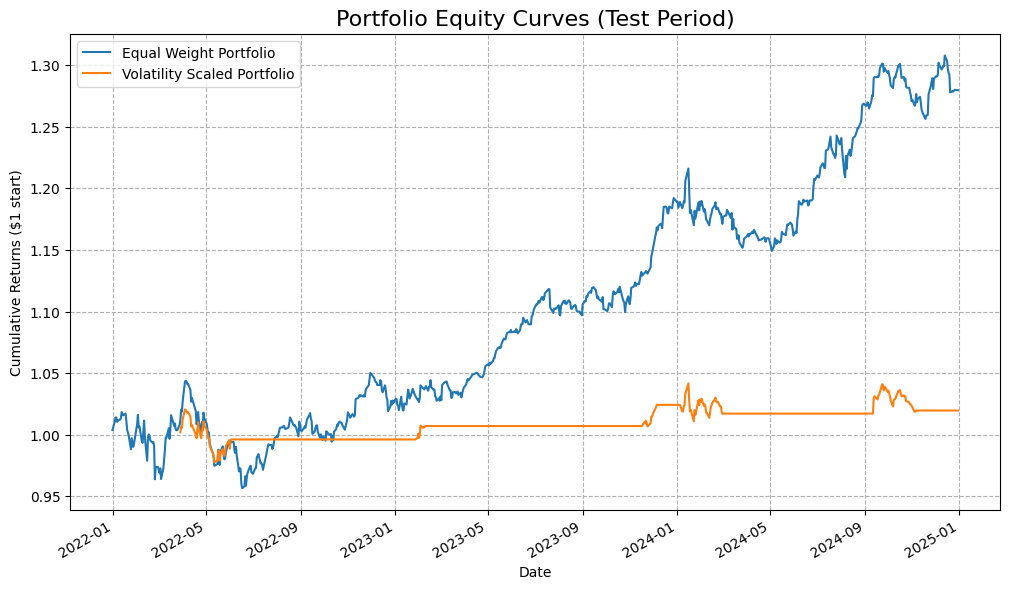


2. Plotting Strategy Correlation Heatmap...


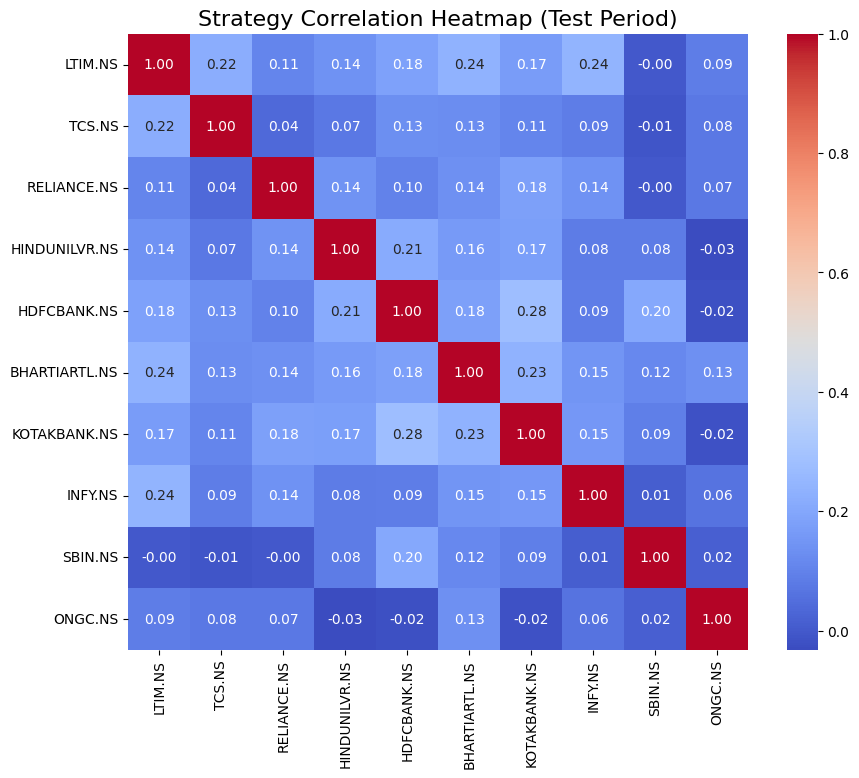


3. Plotting Top 10 Strategy Metrics...


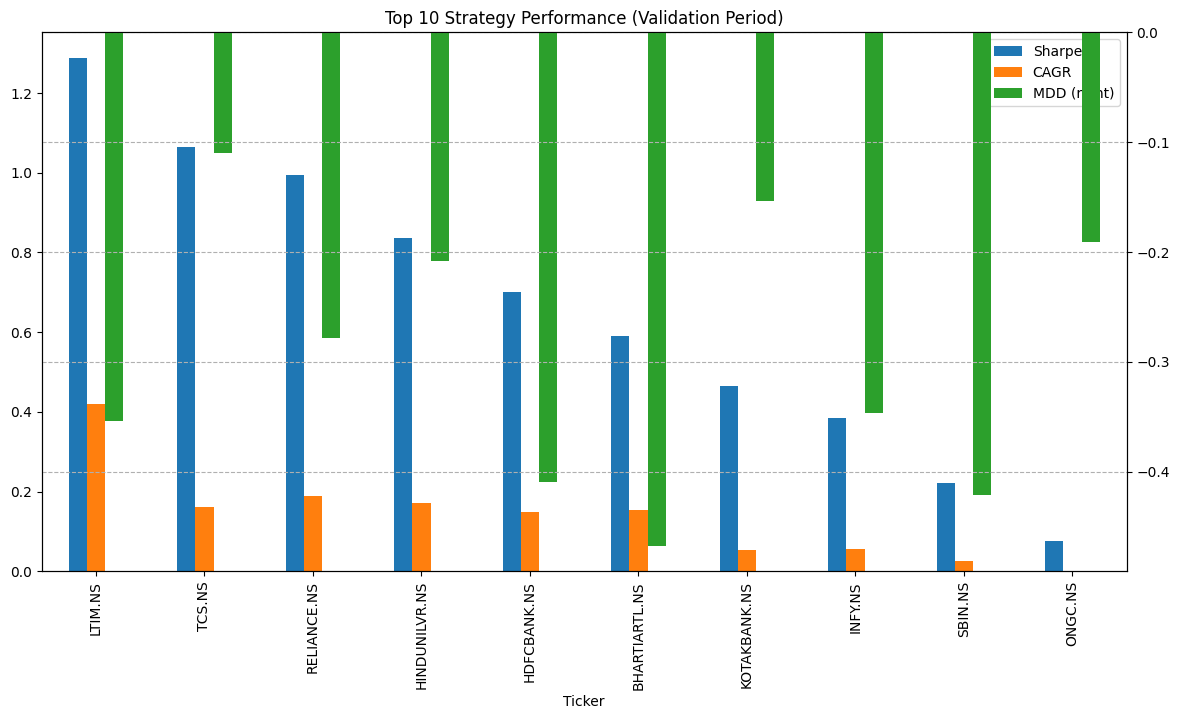


4. Plotting Best Individual Backtest...
  -> Plotting for: LTIM.NS


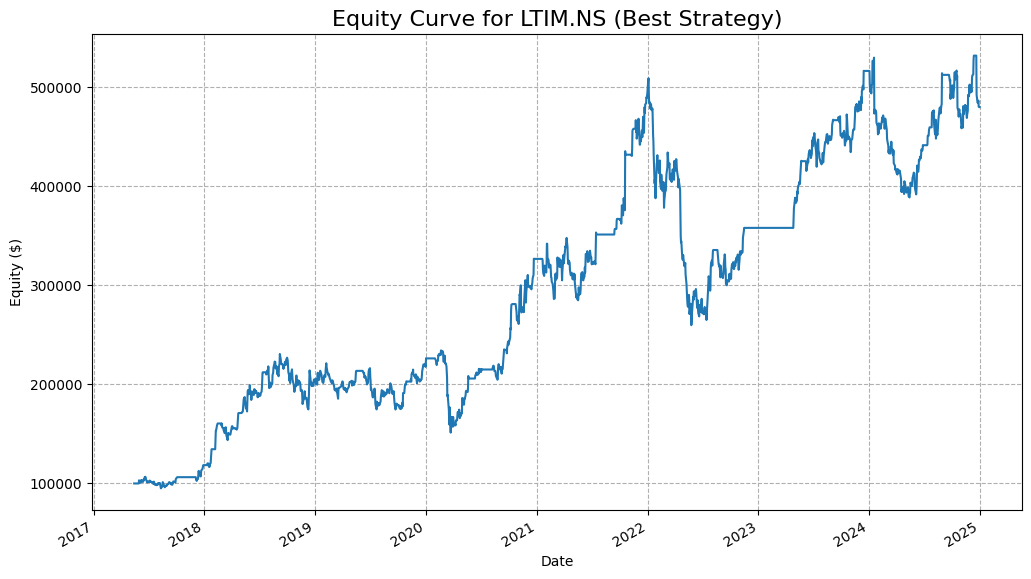


--- Plotting Finished ---


In [170]:
def plot_pipeline_results(pipeline_output):
    """
    Generates all key plots for the pipeline results dictionary.
    (Corrected Version)
    """
    print("--- 🚀 Generating Pipeline Plots ---")

    if not pipeline_output:
        print("Pipeline output is None or empty. Cannot plot.")
        return

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)

        try:
            print("\n1. Plotting Portfolio Equity Curves...")
            eq_equity = (1 + pipeline_output['equal_weight']).cumprod()
            vol_equity = (1 + pipeline_output['vol_scaled']).cumprod()

            plt.figure(figsize=(12, 7))
            eq_equity.plot(label='Equal Weight Portfolio', legend=True)
            vol_equity.plot(label='Volatility Scaled Portfolio', legend=True)

            plt.title('Portfolio Equity Curves (Test Period)', fontsize=16)
            plt.ylabel('Cumulative Returns ($1 start)')
            plt.xlabel('Date')
            plt.grid(True, linestyle='--')
            plt.show()

        except Exception as e:
            print(f"  ⚠ Could not plot equity curves: {e}")

        try:
            print("\n2. Plotting Strategy Correlation Heatmap...")
            corr_matrix = pipeline_output['test_returns'].corr()

            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix,
                        annot=True,
                        cmap='coolwarm',
                        fmt='.2f')

            plt.title('Strategy Correlation Heatmap (Test Period)', fontsize=16)
            plt.show()

        except Exception as e:
            print(f"  ⚠ Could not plot correlation heatmap: {e}")

        try:
            print("\n3. Plotting Top 10 Strategy Metrics...")
            ranked_df = pipeline_output['ranked']


            plot_cols = []
            if 'Sharpe' in ranked_df.columns:
                plot_cols.append('Sharpe')
            if 'CAGR' in ranked_df.columns:
                plot_cols.append('CAGR')
            if 'MDD' in ranked_df.columns:
                plot_cols.append('MDD')


            if not plot_cols:
                print("  ⚠ Could not find metric columns (Sharpe, CAGR, MDD) to plot.")
            else:
                top_10_stats = ranked_df.head(10)[plot_cols]

                sec_y = 'MDD' if 'MDD' in plot_cols else None

                top_10_stats.plot(
                    kind='bar',
                    figsize=(14, 7),
                    title='Top 10 Strategy Performance (Validation Period)',
                    secondary_y=sec_y,
                    grid=True
                )
                plt.xlabel("Ticker")
                plt.grid(axis='y', linestyle='--')
                plt.show()

        except Exception as e:
            print(f"  ⚠ Could not plot Top 10 metrics: {e}")

        try:
            print("\n4. Plotting Best Individual Backtest...")
            top_ticker = pipeline_output['ranked'].index[0]
            print(f"  -> Plotting for: {top_ticker}")

            best_stats = pipeline_output['backtests'][top_ticker]

            plt.figure(figsize=(12, 7))
            best_stats._equity_curve['Equity'].plot()
            plt.title(f'Equity Curve for {top_ticker} (Best Strategy)', fontsize=16)
            plt.ylabel('Equity ($)')
            plt.grid(True, linestyle='--')
            plt.show()


        except Exception as e:
            print(f"  ⚠ Could not plot individual backtest: {e}")

    print("\n--- Plotting Finished ---")



plot_pipeline_results(out)